# Using NLopt optimizers

We have an interface to [NLopt](https://nlopt.readthedocs.io/en/latest/).

NLopt is a free open-source library that provides a lot of optimizers of different kinds.
There are global and local optimizers, gradient or gradient-free.
For a full list, see [here](https://nlopt.readthedocs.io/en/latest/NLopt_Algorithms/).

To illustrate the interface, we import the usual example on GPR

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import jax
import jax.numpy as jnp

from gpx.models import GPR
from gpx.kernels import SquaredExponential
from gpx.parameters import Parameter
from gpx.priors import NormalPrior
from gpx.bijectors import Softplus, Identity

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("dark_background")

%load_ext autoreload
%autoreload 2

In [2]:
jax.config.x64_enabled

True

In [3]:
train_x = jnp.linspace(0, 1, 100)
key = jax.random.PRNGKey(0)
train_y = jnp.sin(train_x * (2 * jnp.pi)) + jax.random.normal(
    key, shape=train_x.shape
) * jnp.sqrt(0.04)
test_x = jnp.linspace(-0.5, 1.5, 51)
test_f = jnp.sin(test_x * (2 * jnp.pi))

train_x = train_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)
test_x = test_x.reshape(-1, 1)
test_f = test_f.reshape(-1, 1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


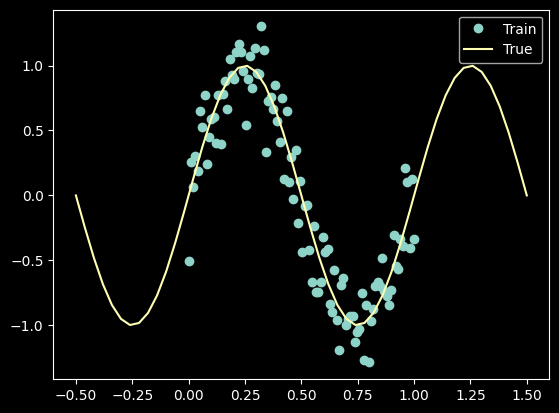

In [4]:
plt.plot(train_x, train_y, "o", label="Train")
plt.plot(test_x, test_f, label="True")
plt.legend()

In [5]:
# create a model with default parameters
model = GPR(
    kernel=SquaredExponential(),
)

model.print()

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬─────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │   value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │       1 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼─────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │       1 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴─────────┘


### NLoptWrapper

The NLopt optimizers can be used in GPX via the `NLoptWrapper` that you find in `gpx.optimizers`.
This wrapper is needed to have an interface that is very similar to the original NLopt one.

For example, the original interface from the [tutorial](https://nlopt.readthedocs.io/en/latest/NLopt_Tutorial/#example-in-python):

```python
# [...]

opt = nlopt.opt(nlopt.LD_MMA, 2)
opt.set_lower_bounds([-float('inf'), 0])
opt.set_min_objective(myfunc)
opt.add_inequality_constraint(lambda x,grad: myconstraint(x,grad,2,0), 1e-8)
opt.add_inequality_constraint(lambda x,grad: myconstraint(x,grad,-1,1), 1e-8)
opt.set_xtol_rel(1e-4)
x = opt.optimize([1.234, 5.678])
minf = opt.last_optimum_value()

# [...]
```

In GPX it's pretty much the same, except that we work with a `ModelState`, and that we have bounds for the parameters in the form of `forward_transform` and `backward_transform`. The wrapper takes into account everything automatically.
You can access the NLopt optimizer from the `.opt` attribute of the wrapper, put bounds, constraints, etc.
Here we just set the relative tolerance, as e.g. the bounds are imposed by the transformations associated with our parameters

In [6]:
import nlopt
from gpx.optimizers import NLoptWrapper

optim = NLoptWrapper(model.state, nlopt.LD_MMA)
optim.opt.set_xtol_rel(1e-4)

optim_state, optim_result = optim.optimize(model.state, train_x, train_y, model.state.loss_fn)

optim_state.print_params()

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.411055 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.217112 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴──────────┘


### Calling `model.fit_nlopt`

To make the optimization easier, models have an utility function `fit_nlopt`

In [7]:
# new starting point
model = model.randomize(jax.random.PRNGKey(2023))
model.print()

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.814884 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.304    │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴──────────┘


In [8]:
optim = NLoptWrapper(model.state, nlopt.LD_MMA)
optim.opt.set_xtol_rel(1e-4)

model.fit_nlopt(train_x, train_y, opt=optim, minimize=True)

model.print()
print('is fitted:', model.state.is_fitted)

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.411059 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.217114 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴──────────┘
is fitted: True


It is also possible to perform multiple restarts by providing `num_restarts` to the function

In [9]:
model.fit_nlopt(train_x, train_y, opt=optim, minimize=True, num_restarts=5, key=jax.random.PRNGKey(3))

model.print()
print('is fitted:', model.state.is_fitted)

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.411059 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.217113 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴──────────┘
is fitted: True


**Take home message**: you can fit your models using `fit_nlopt` and providing a `NLoptWrapper` to it, similarly to what you do with `fit`

### Using boundaries/constraints from NLopt

An important caveat to keep in mind: if bounds/constraints are specified in NLopt, then the parameters should have "null" forward and backward transforms, because the mixing of these transformations and the additional ones specified with NLopt will likely not do what you want.

For example, if we use the `GN_ESCH` optimizer, we must provide a finite boundary for the parameters.
If we enforce them to be positive with a nonlinear transformation like softplus, we will obtain strange results:

In [10]:
# create a model with default parameters
model = GPR(
    kernel=SquaredExponential(),
)

optim = NLoptWrapper(model.state, nlopt.GN_ESCH)
optim.opt.set_lower_bounds([0., 0.])
optim.opt.set_upper_bounds([10., 10.])
optim.opt.set_maxeval(500) # run for 500 steps

model.fit_nlopt(train_x, train_y, opt=optim, minimize=True)

model.print()
print('is fitted:', model.state.is_fitted)

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.706873 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.73211  │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴──────────┘
is fitted: True


You see that it is going in the wrong direction. Instead, if we want to impose constraints with NLopt, it's better to not impose them in GPX by using the `identity` (null) transformation

In [11]:
# create a model with default parameters
model = GPR(
    kernel=SquaredExponential(),
    sigma=Parameter(1.0, True, Identity(), NormalPrior()),
    kernel_params=dict(lengthscale=Parameter(1.0, True, Identity(), NormalPrior()))
)

optim = NLoptWrapper(model.state, nlopt.GN_ESCH)
optim.opt.set_lower_bounds([0., 0.])
optim.opt.set_upper_bounds([10., 10.])
optim.opt.set_maxeval(500) # run for 500 steps

model.fit_nlopt(train_x, train_y, opt=optim, minimize=True)

model.print()
print('is fitted:', model.state.is_fitted)

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ Identity   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.242172 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ Identity   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.280894 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴──────────┘
is fitted: True


And you see that everything is going in the right direction.

**Take home message**: if you impose constraints with NLopt, then use the `identity` transformation for you parameters. If you don't want to impose constraints with NLopt, use the transformations to impose boundaries (e.g., using `softplus`)